<a href="https://colab.research.google.com/github/patison5/FAIntelligence/blob/main/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA_(%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%BC%D0%B5%D0%BD%D0%B0%D1%8E%D1%89%D0%B8%D0%B9%D1%81%D1%8F_learning_rate__Adam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Инициализация

In [1]:
import numpy as np

#### Инициализация лямба функций формулы П.3 из книжки Пантелеева

In [2]:
''' 
    Мультифункция (рис П.3)
    Глобальный экстремум Z = 837,9657 
'''

P4Multi = lambda v: v[0] * np.sin(4 * np.pi * v[0]) + v[1] * np.sin(4 * np.pi * v[1])
P4MultiGrad = lambda v: np.array([ 4 * np.pi * v[0] * np.cos(4 * np.pi * v[0]) + np.sin(4 * np.pi * v[0]), 4 * np.pi * v[1] * np.cos(4 * np.pi * v[1]) + np.sin(4 * np.pi * v[1]) ])


### Реализация классического градиентного спуска

In [3]:
def classic_gradient_descent(
    gradient, start, learn_rate, n_iter=250, eps=1e-06
):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * gradient(vector)
        if np.all(np.abs(diff) <= eps):
            break
        vector += diff
    return vector

#### Тестирование классического градиентного спуска

Классический градиентный спуск <br>
Функция: у = 𝑣²<br>
Градиент: y = 2𝑣<br>

In [4]:
classic_gradient_descent(
  gradient=lambda v: 2 * v, start=10.0, learn_rate=0.2
)

2.210739197207331e-06

Классический градиентный спуск <br>
Функция: у = 𝑣⁴ - 5𝑣² - 3𝑣 <br>
Градиент: y = 4𝑣³ − 10𝑣 − 3 <br>

In [5]:
classic_gradient_descent(
  gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0,
  learn_rate=0.2
)

-1.0136634890267242

Классический градиентный спуск для двух и более переменных<br>
Функция: у = 𝑣₁² + 𝑣₂⁴ <br>
Градиент: y = 2𝑣₁, 4𝑣₂³ <br>

In [6]:
classic_gradient_descent(
  gradient=lambda v: np.array([2 * v[0], 4 * v[1]**3]),
  start=np.array([1.0, 1.0]), learn_rate=0.2, eps=1e-08
)

array([3.44994837e-56, 4.84026715e-02])

Классический градиентный спуск для функции из книжки Пантелеева

In [7]:
classic_gradient_descent(
  gradient=P4MultiGrad,
  start=np.array([838., 9658.]), learn_rate=0.2, eps=1e-08
)

array([3.13210253e+28, 1.26018218e+23])

### Модификация градиентного спуска (меняющийся learning_rate)

In [8]:
def gradient_descent_mlr(
    gradient, start, learn_rate=0.2, n_iter=50, eps=1e-06
):
    vector = start
    for idx in range(n_iter):
        lr = learn_rate / min((1 + idx), 10)
        diff = -lr * gradient(vector)
        if np.all(np.abs(diff) <= eps):
            break

        # print(vector, lr, diff)
        vector += diff
    return vector

#### Тестирование модифицированного градиентного спуска

In [9]:
print(classic_gradient_descent(
  gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0, learn_rate=0.1
))

print(gradient_descent_mlr(
  gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0, learn_rate=0.3
))

1.2854013303966605
1.7139383192807744


### Алгоритм Adam

In [10]:
from math import sqrt
from numpy import asarray
from numpy import arange
from numpy.random import rand
from numpy.random import seed
from numpy import meshgrid
from matplotlib import pyplot as plt

from matplotlib.patches import Circle, Ellipse
from mpl_toolkits.mplot3d import Axes3D, art3d

In [11]:
def f(x, y):
	return x**2.0 + y**2.0
 
def df(x, y):
	return asarray([x * 2.0, y * 2.0])
 
# def f(x, y):
# 	return 100*(y - x**2)**2 + (1 - x)**2
 
# def df(x, y):
# 	return asarray([-400*x*(-x**2 + y) + 2*x - 2, -200*x**2 + 200*y])

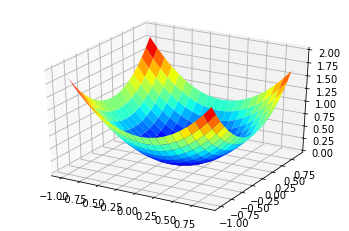

In [12]:
r_min, r_max = -1.0, 1.0

xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)

x, y = meshgrid(xaxis, yaxis)

results = f(x, y)

figure = plt.figure()
axis = figure.gca(projection='3d')
axis.plot_surface(x, y, results, cmap='jet')

plt.show()

In [17]:
def adam(f, df, bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
  solutions = list()

  # Генерация стартовой точки
  x = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
  score = f(x[0], x[1])

  # инициализация момента и экспоненциально взвешенной нормы
  m = [0.0 for _ in range(bounds.shape[0])]
  v = [0.0 for _ in range(bounds.shape[0])]

  for t in range(n_iter):
    # Считаем градиент для текущего временного шага
    g = df(x[0], x[1])

    for i in range(bounds.shape[0]):

      # Обновление 1-го момента с использованием градиента и гиперпараметра betta1
      m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]

      # Обновление 2-го момента с использованием градиента и гиперпараметра betta2
      v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2

      # Исправление момента с учетом погрешности
      mhat = m[i] / (1.0 - beta1**(t+1))

      # Исправление момента с учетом погрешности
      vhat = v[i] / (1.0 - beta2**(t+1))

      # Вычисление параметра
      x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)

    # Сохранение истории
    solutions.append(x.copy())

  return solutions


bounds = asarray([[-1.0, 1.0], [-1.0, 1.0]])
solutions = adam(f, df, bounds, 60, 0.02, 0.8, 0.999)

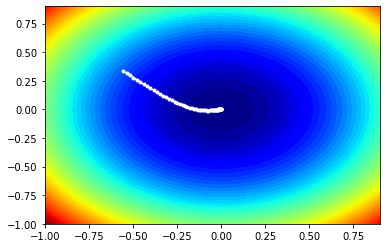

In [18]:
xaxis = arange(bounds[0,0], bounds[0,1], 0.1)
yaxis = arange(bounds[1,0], bounds[1,1], 0.1)

x, y = meshgrid(xaxis, yaxis)

results = f(x, y)

plt.contourf(x, y, results, levels=50, cmap='jet')

solutions = asarray(solutions)
plt.plot(solutions[:, 0], solutions[:, 1], '.-', color='w')

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 0.92, '3д проекция')

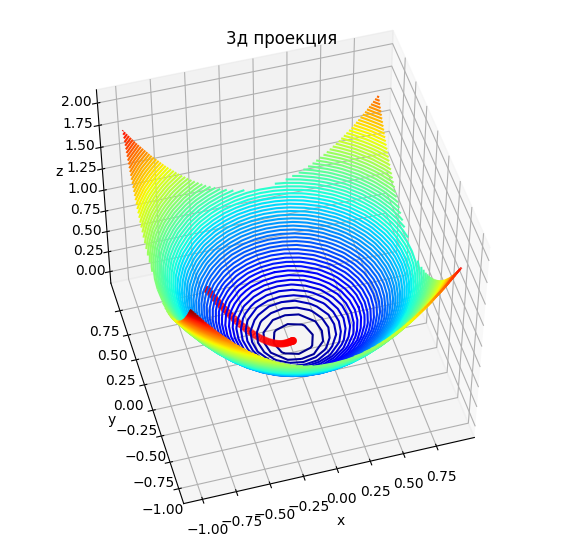

In [20]:
fig = plt.figure(figsize=(7, 7), dpi=100)
ax = plt.axes(projection='3d')
ax.contour3D(x, y, results, 80, cmap='jet')

rs = f(solutions[:, 0], solutions[:, 1])
ax.scatter(solutions[:, 0], solutions[:, 1], rs, c='red')

ax.view_init(50, -106)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("3д проекция")

In [39]:
def add_point(ax, x, y, z, fc = None, ec = None, radius = 0.005):
       xy_len, z_len = ax.get_figure().get_size_inches()
       axis_length = [x[1] - x[0] for x in [ax.get_xbound(), ax.get_ybound(), ax.get_zbound()]]
       axis_rotation =  {'z': ((x, y, z), axis_length[1]/axis_length[0]),
                         'y': ((x, z, y), axis_length[2]/axis_length[0]*xy_len/z_len),
                         'x': ((y, z, x), axis_length[2]/axis_length[1]*xy_len/z_len)}
       for a, ((x0, y0, z0), ratio) in axis_rotation.items():
           p = Ellipse((x0, y0), width = radius, height = radius*ratio, fc=fc, ec=ec)
           ax.add_patch(p)
           art3d.pathpatch_2d_to_3d(p, z=z0, zdir=a)

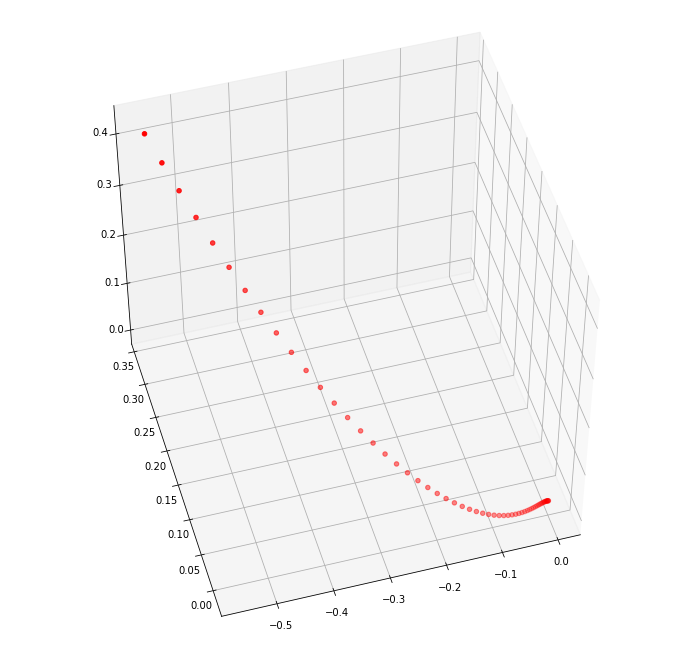

In [57]:
xs = arange(bounds[0,0], bounds[0,1], 0.1)
ys = arange(bounds[1,0], bounds[1,1], 0.1)

x, y = meshgrid(xaxis, yaxis)
z = f(x, y)

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.scatter(solutions[:, 0], solutions[:, 1], rs, c='red')
# ax.plot_trisurf(x.flatten(), y.flatten(), z.flatten(), linewidth=0.2, antialiased=True, zorder=1)
ax.view_init(50, -106)

add_point(ax, 25, 35, 0, radius=1)


# for i in range(0, solutions.shape[0]):
#   add_point(ax, solutions[i, 0], solutions[i, 1], rs[i], radius=1)

plt.show()